In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
Normaloperation = pd.read_csv("Normaloperation.csv",header=None)
Faultyoperation = pd.read_csv("Faultyoperation.csv",header=None)

In [7]:
Normaloperation.shape, Faultyoperation.shape

((18, 558), (18, 559))

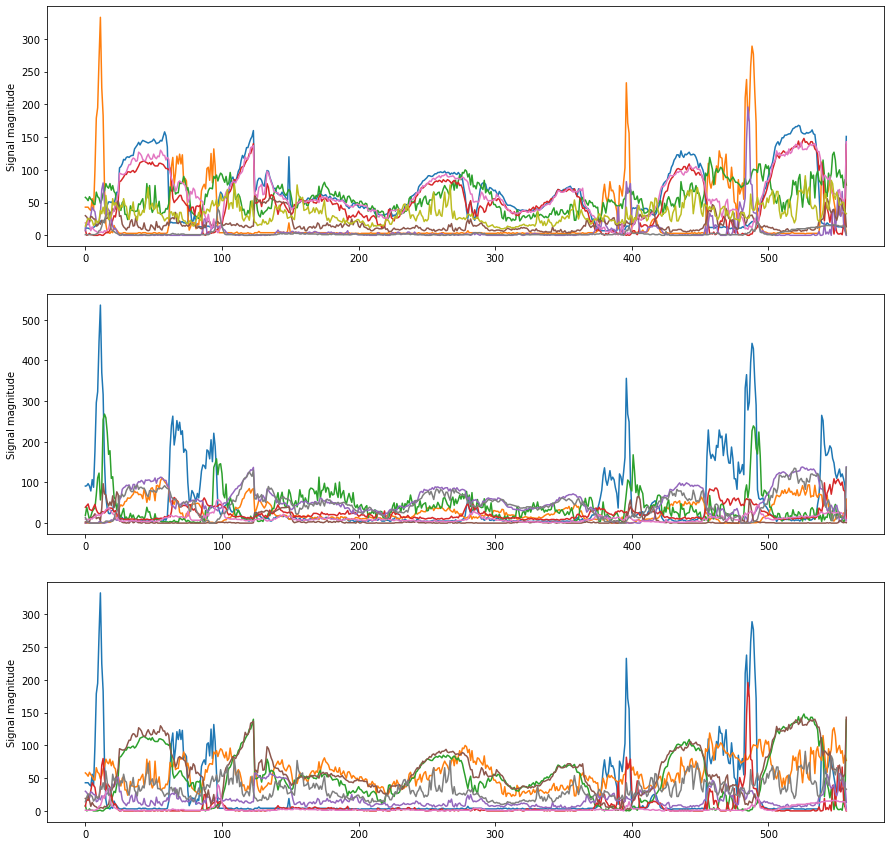

In [30]:
#plot sensor data
fig, axs = plt.subplots(3,1,figsize=(15,15))
axs[0].plot(Normaloperation.iloc[np.arange(0,17,2),:].T)
axs[0].set_title("plot of ozone at all locations over time")
axs[0].set_ylabel('Signal magnitude')

axs[1].plot(Normaloperation.iloc[np.arange(1,17,2),:].T)
axs[1].set_ylabel('Signal magnitude')

axs[2].plot(Normaloperation.iloc[np.arange(2,17,2),:].T)
axs[2].set_ylabel('Signal magnitude')
plt.show()


In [12]:
Normaloperation

,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,557
0,11,11,11,10,10,11,12,14,16,16,...,15,14,14,13,13,13,12,12,12,151
1,91,92,97,91,79,107,88,176,296,323,...,148,122,110,122,133,114,121,109,93,7
2,43,43,43,40,38,56,39,99,179,195,...,51,39,26,39,45,30,35,33,18,3
3,0,0,1,0,0,0,0,0,0,0,...,5,10,24,19,13,18,15,25,13,59
4,58,56,53,59,55,53,48,47,66,59,...,127,115,89,95,100,88,92,73,85,77
5,19,39,23,8,17,28,34,37,70,111,...,35,46,18,29,26,14,14,2,8,31
6,8,0,1,3,1,1,0,0,0,0,...,2,15,5,2,2,3,1,17,7,139
7,39,43,47,34,32,31,39,46,33,26,...,109,97,104,108,100,93,101,81,78,12
8,7,18,16,21,31,43,39,36,22,20,...,37,8,30,69,32,29,67,19,7,0
9,0,1,5,3,0,0,0,0,0,0,...,28,41,44,29,3,5,11,16,11,138


array([ 0,  2,  4,  6,  8, 10, 12, 14, 16])